# AXI Proxy

In [1]:
import logging
import os
import random
import re
import subprocess
from dataclasses import dataclass
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
from fpga_mngr_interface.FpgaManagerInterface import FpgaManagerInterface
from zynqmp_pl_ps import AxiProxy, Udmabuf, UioDev

## Programming the FPGA

We check if the FPGA is programmed, and if that is not the case, we program it with the appropriate bitstream and device tree overlay.

In [2]:
# logging.basicConfig(level=logging.DEBUG)

fmi = FpgaManagerInterface()
is_programmed = fmi.is_programmed()

try:
    UioDev.get_uio_dev_file("AxiProxy", "hp")
    ap_found = True
except RuntimeError:
    ap_found = False

print(f"is programmed: {is_programmed}, AXI Proxy found: {ap_found}")

if not is_programmed or not ap_found:
    print("Re-programming the FPGA")
    fmi.remove()
    fmi.program_bitstream(
        "/lib/firmware/xilinx/axi_proxy/axi_proxy.bit.bin",
        "/lib/firmware/xilinx/axi_proxy/axi_proxy.dtbo",
    )

is programmed: True, AXI Proxy found: True


## Test runner

In [3]:
@dataclass(frozen=True)
class TestConfig:
    port_name: str
    udmabuf_flags: int
    axi_cache: int
    axi_prot: int
    axi_user: int

In [4]:
#! /usr/bin/env python3

import random
import time


class AxiProxyTest:
    OFFS = 0x100

    def __init__(self, test_config: TestConfig):
        dev = UioDev.get_uio_dev_file("AxiProxy", search_note=test_config.port_name)
        self.ap = AxiProxy.AxiProxy(dev)

        self.udmabuf = Udmabuf.Udmabuf("axi:udmabuf@0x0", test_config.udmabuf_flags)
        assert self.udmabuf._get_value("dma_coherent") == 1

        self.ap.config_axi(
            cache=test_config.axi_cache,
            prot=test_config.axi_prot,
            user=test_config.axi_user,
        )

        self.rnd = random.Random(123)

    def hw_write(self):
        data = self.rnd.randint(0, 2 ** 32 - 1)
        duration = self.ap.write(self.udmabuf.phys_addr + self.OFFS, [data, 0, 0, 0])
        print(f"AxiProxy: write data = {data:08x}, duration = {duration}")

        return data, duration

    def hw_read(self):
        data_rbv, duration = self.ap.read(self.udmabuf.phys_addr + self.OFFS)
        print(f"AxiProxy: read data  = {data_rbv[0]:08x}, duration = {duration}")

        return data_rbv[0], duration

## Measurement configuration

In [5]:
udmabuf = Udmabuf.Udmabuf("axi:udmabuf@0x0")
BUFFER_SIZE = udmabuf.buf_size
print(f"Buffer size: {BUFFER_SIZE}")
del udmabuf

Buffer size: 33554432


In [6]:
NR_MEAS_PER_PORT = 100

CONFIGS = {
    "hp": TestConfig("hp", os.O_SYNC, axi_cache=0, axi_prot=0, axi_user=0),
    "hpc": TestConfig("hpc", 0, axi_cache=15, axi_prot=2, axi_user=1),
    "acp": TestConfig("acp", 0, axi_cache=15, axi_prot=2, axi_user=1),
}

## Measurement

In [7]:
np.random.seed(1234)

meas = dict()

for interface, config in CONFIGS.items():

    test = AxiProxyTest(config)

    durs_rd = []
    durs_wr = []

    print("==================================")
    print(interface)

    for i in range(NR_MEAS_PER_PORT):
        _, duration = test.hw_write()
        durs_wr.append(duration)

    for i in range(NR_MEAS_PER_PORT):
        _, duration = test.hw_read()
        durs_rd.append(duration)

    meas[interface] = dict()
    meas[interface]["rd"] = durs_rd
    meas[interface]["wr"] = durs_wr

hp
AxiProxy: write data = 0d67b366, duration = 37
AxiProxy: write data = 6840ff07, duration = 36
AxiProxy: write data = 09c47055, duration = 36
AxiProxy: write data = 550ae889, duration = 37
AxiProxy: write data = da22594f, duration = 36
AxiProxy: write data = 28dfa298, duration = 37
AxiProxy: write data = 3ec3068c, duration = 36
AxiProxy: write data = 98fc4743, duration = 36
AxiProxy: write data = 11e374ee, duration = 37
AxiProxy: write data = 72c53633, duration = 37
AxiProxy: write data = e7c834d3, duration = 37
AxiProxy: write data = 246595df, duration = 36
AxiProxy: write data = 056fb885, duration = 36
AxiProxy: write data = e9412995, duration = 37
AxiProxy: write data = 92cadf50, duration = 36
AxiProxy: write data = 43ec1f85, duration = 37
AxiProxy: write data = d67c8720, duration = 36
AxiProxy: write data = c4cfbb8a, duration = 36
AxiProxy: write data = cd2ee163, duration = 37
AxiProxy: write data = 50b51605, duration = 36
AxiProxy: write data = 8343b946, duration = 37
AxiProxy: 

AxiProxy: write data = 7e95e03c, duration = 46
AxiProxy: write data = 0d6c6796, duration = 46
AxiProxy: write data = dc94e704, duration = 46
AxiProxy: write data = 6bb7097e, duration = 46
AxiProxy: write data = 5bd1d560, duration = 46
AxiProxy: write data = c5317618, duration = 46
AxiProxy: write data = c0f365e3, duration = 46
AxiProxy: write data = 2e40c929, duration = 46
AxiProxy: write data = 6a2b9275, duration = 46
AxiProxy: write data = 801f1dce, duration = 46
AxiProxy: write data = 8f1c9eec, duration = 47
AxiProxy: write data = 5e572499, duration = 47
AxiProxy: write data = ebf36820, duration = 47
AxiProxy: write data = 527deda5, duration = 45
AxiProxy: write data = f1b8788c, duration = 46
AxiProxy: write data = 636f5f4a, duration = 46
AxiProxy: write data = 1b82e2bb, duration = 45
AxiProxy: read data  = 1b82e2bb, duration = 79
AxiProxy: read data  = 1b82e2bb, duration = 73
AxiProxy: read data  = 1b82e2bb, duration = 76
AxiProxy: read data  = 1b82e2bb, duration = 73
AxiProxy: rea

AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: read data  = 1b82e2bb, duration = 13
AxiProxy: rea

## Plotting

In [8]:
@dataclass
class MeasData:
    hp: np.array
    hpc: np.array
    acp: np.array


def process_meas(data: dict, tx_type: str):
    hp = np.array(data["hp"][tx_type])
    hpc = np.array(data["hpc"][tx_type])
    acp = np.array(data["acp"][tx_type])

    return MeasData(hp=hp, hpc=hpc, acp=acp)


def plot_graph_hist(
    meas_hp: np.array,
    meas_hpc: np.array,
    meas_acp: np.array,
    title: str,
):
    fig = plt.figure(figsize=(12, 8))
    ax1, ax2 = fig.subplots(1, 2, gridspec_kw={"width_ratios": [3, 1]}, sharey=True)

    ax1.plot(meas_hp, label="HP")
    ax1.plot(meas_hpc, label="HPC")
    ax1.plot(meas_acp, label="ACP")
    ax1.grid(True)
    ax1.legend(loc="upper right")
    ax1.set_ylabel("delay [clk cycles]")
    ax1.set_xlabel("iteration")

    delay_max = np.max([np.max(meas_hp), np.max(meas_hpc), np.max(meas_acp)])
    delay_min = np.min([np.min(meas_hp), np.min(meas_hpc), np.min(meas_acp)])

    HIST_CONF = {
        "orientation": "horizontal",
        "alpha": 0.7,
    }
    ax2.hist(meas_hp, label="HP", bins=30, range=(delay_min, delay_max), **HIST_CONF)
    ax2.hist(meas_hpc, label="HPC", bins=30, range=(delay_min, delay_max), **HIST_CONF)
    ax2.hist(meas_acp, label="ACP", bins=30, range=(delay_min, delay_max), **HIST_CONF)
    ax2.grid(True)
    ax2.legend(loc="upper right")
    ax2.set_xlabel("counts")

    fig.suptitle(title)

In [9]:
data_read = process_meas(meas, "rd")
data_write = process_meas(meas, "wr")

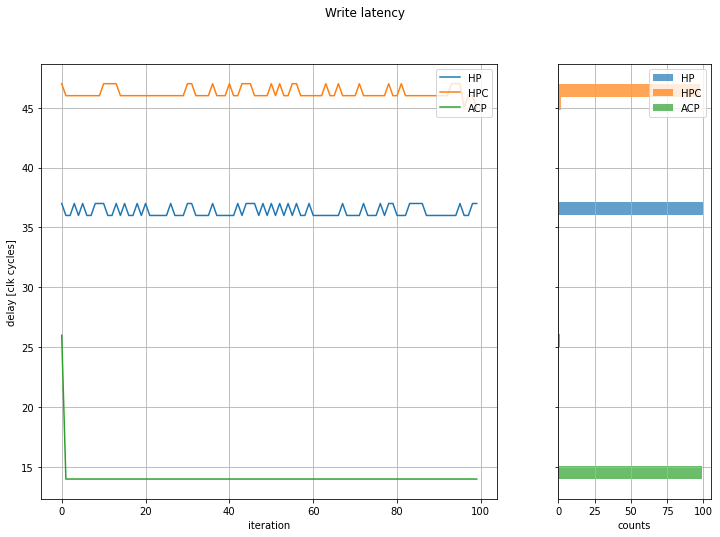

In [10]:
plot_graph_hist(data_write.hp, data_write.hpc, data_write.acp, "Write latency")

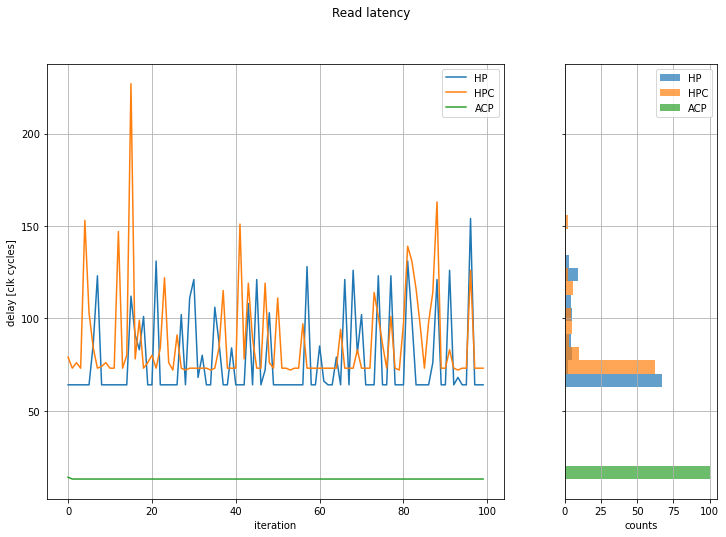

In [11]:
plot_graph_hist(data_read.hp, data_read.hpc, data_read.acp, "Read latency")

## Conclusion
